# k-NN graph : ranks of edges

The k-NN graphs we get from low dimensional vs. high dimensional data representation differ. Here we look at how much they differ. To measure the similarity between a point's neiborhood before and after dimensionality reduction (UMAP), we use the truncated-Kendall Tau and the Jaccard similarity. We use a different neighborhood size for each dataset: we use the $k$ value that was used in the initial clustering experiment (yielding good UMAP+HDBSCAN partition).

The distributions of the neighborhood similarities over the set of vertices of these two measures are really similar. However, the distributions's shape differ quite significantly from one dataset to the other. Consequence of the neighborhood sizes and of the dataset properties? 

We know from previous experiments that the higher order cliques of the neighborhood graphs are better preserved by a graph partition than it is by the ground truth partition: and this is true for both low and high k-NN graphs. But not all neighbors are equal. Would the ranks of the edges incident to a vertex - ranks in terms of different measures (high dim distance, low dim distance and UMAP weight) - be indicative of the status (internal/external) of the edge in the ground-truth clustering?
The high dimensional distance ranks and the UMAP weights ranks are both indicative of the edge status proportions in the ground truth partition. However, the low dimensional distance ranks are a lot more indicative.


In [1]:
!git branch

* main


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent
from scipy.spatial.distance import euclidean

import cdlib.algorithms as cd
import itertools
import collections
import igraph as ig
import leidenalg as la

from community import community_louvain

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'karateclub', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# Functions

In [1]:
def enrich_graph_edge_properties(G, vertex_high_representation=None, vertex_low_representation=None):
    
    G.es['umap_weight'] = G.es['weight']
    
    simplices = G.cliques(min=3, max=3)
    edge_in_simplex = []
    for x in simplices:
        edge_in_simplex += G.get_eids([pair for pair in itertools.combinations(x, r=2)], directed=False)
    G.es["nb_triangles"] = 0
    for k, v in collections.Counter(edge_in_simplex).items():
        G.es[k]["nb_triangles"] = v
    
    if(vertex_low_representation is not None):
        G.es['lowdim_dist'] = [euclidean( vertex_low_representation[e.source], 
                                         vertex_low_representation[e.target] ) 
                               for e in G.es]
        
    if(vertex_high_representation is not None):
        G.es['highdist_dist'] = [euclidean( vertex_high_representation[e.source], 
                                         vertex_high_representation[e.target] ) 
                               for e in G.es] 
        
    for v in G.vs:
        x = {e:G.es[e]['highdist_dist'] for e in G.incident(v)}
        for i,e in enumerate(sorted(x, key=x.get)):
            G.es[e]['highdist_rank'] = i
            
    for v in G.vs:
        x = {e:G.es[e]['lowdim_dist'] for e in G.incident(v)}
        for i,e in enumerate(sorted(x, key=x.get)):
            G.es[e]['lowdist_rank'] = i
    
    for v in G.vs:
        x = {e:G.es[e]['umap_weight'] for e in G.incident(v)}
        for i,e in enumerate(sorted(x, key=x.get)):
            G.es[e]['umap_rank'] = i
    return(G)

In [14]:
# Plotting the features using boxes
def barPlot_split_on(what, split_on, edge_df, nb_cols=3):
    print(collections.Counter(edge_df[split_on]))
    nb_rows = int(np.ceil(len(what)/nb_cols))
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(15, 4*nb_rows))
    for i, var in enumerate(what):
        w_row = (i//nb_cols)
        w_col = (i%nb_cols)
        plt.subplot(nb_rows, nb_cols, i+1)
        if(var in ['highdist_rank', 'lowdist_rank', 'umap_rank'] ):
            sns.histplot(x = var, data = edge_df, hue=split_on, discrete=True)
        elif(var in ['bi_directional']):
            df = edge_df.groupby([var, split_on]).size().reset_index(name='Count')
            df.loc[df[var], 'Count'] = df[df[var]]['Count']//2
            sns.barplot(x=var, y="Count", data=df, ci=None, hue=split_on)
        else:
            sns.boxplot(x = split_on, y = var, data = edge_df)
        # axes[w_row][w_col].title.set_text(var)
        # if(w_row < nb_rows-1):
        #     plt.xlabel('')
        # plt.ylabel('')

In [ ]:
def jaccard_similarity(v1, v2):
    num = len(set(v1).intersection(set(v2)))
    denom = len(set(v1).union(set(v2)))
    return(num/denom)

In [ ]:
from itertools import combinations as comb
## input: 2 lists X and Y of arbitrary length
## output: similarity in [0,1]
def adaptedKendallTau(X, Y):
    SI = [x for x in X if x in Y] ## intersection - list to keep the order as in X
    SX = set(X).difference(SI)    ## in X only
    SY = set(Y).difference(SI)    ## in Y only
    tau = 0
    ## SI: pairs in intersection
    l = len(SI)
    y = [Y.index(z) for z in SI]
    s = sum([a<b for a,b in comb(y,2)])
    tau += 2*s - l*(l-1)/2 ## pos-neg pairs a la Kendall-tau.
    ## SX, resp. SY and SI: one element in intersection
    x = [X.index(z) for z in SX]
    y = [Y.index(z) for z in SY]
    i = [X.index(z) for z in SI]
    s = 2*sum([a>b for a in x for b in i]) - len(x)*len(i)
    tau += s
    s = 2*sum([a>b for a in y for b in i]) - len(y)*len(i)
    tau += s
    ## ze rest
    tau -= len(SX)*len(SY)
    tau += l*(l+1)/2
    tau /= (len(X)*len(Y))
    return((tau+1)/2)

# Neighborhood similarities: low vs. high dimensional

* Not all low dimensional neighborhoods have the requested sizes - need to see what are the criterion in UMAP

In [162]:
dataset_id = 4
set_op_mix_ratio = 1
params = get_dataset_params(dataset_id)
raw_data, targets, dataset_name = get_dataset(dataset_id)
G = knn_digraph(raw_data, params['n_neighbors'])
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
umap_rep = umap.UMAP(n_neighbors=params['n_neighbors'],n_components=params['n_components'], 
                             min_dist=params['min_dist'], random_state=params['random_state']).fit_transform(raw_data)
G = enrich_graph_edge_properties(G, 
                             vertex_high_representation=raw_data, 
                             vertex_low_representation=umap_rep)
G_low = knn_digraph(umap_rep, params['n_neighbors'])
G_low = graph_edge_class_from_labels(G_low, targets, attribute_name = 'internal')
G_low = enrich_graph_edge_properties(G_low, 
                             vertex_high_representation=umap_rep)

In [163]:
for v in G.vs:
    x = {G.es[e].target:G.es[e]['highdist_dist'] for e in G.incident(v)}
    v['ordered_neighors'] = sorted(x, key=x.get)

In [164]:
for v in G_low.vs:
    x = {G_low.es[e].target:G_low.es[e]['highdist_dist'] for e in G_low.incident(v)}
    v['ordered_neighors'] = sorted(x, key=x.get)

In [165]:
for v in range(G.vcount()):
    G.vs[v]['neigh_kendall'] = adaptedKendallTau(G.vs[v]['ordered_neighors'], G_low.vs[v]['ordered_neighors'])
    G.vs[v]['neigh_jaccard'] = jaccard_similarity(G.vs[v]['ordered_neighors'], G_low.vs[v]['ordered_neighors'])

<AxesSubplot:xlabel='neigh_kendall', ylabel='Count'>

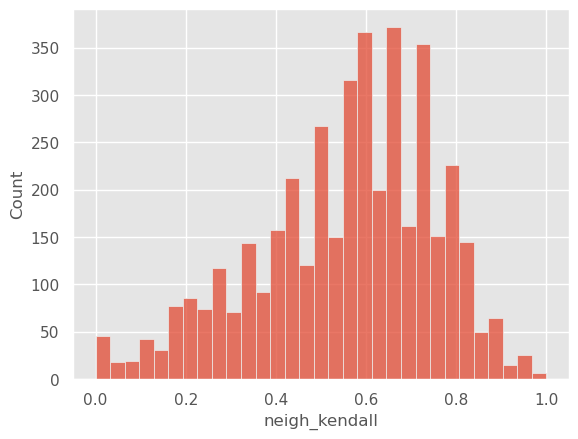

In [166]:
vertex_df = G.get_vertex_dataframe()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1,2,1)
sns.histplot(vertex_df, x='neigh_kendall')
plt.subplot(1,2,2)
sns.histplot(vertex_df, x='neigh_jaccard')

In [84]:
def vertex_neighborhood_sim(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    params = get_dataset_params(dataset_id)
    display(Markdown(f'## {dataset_name}-{params["n_neighbors"]} neighbors'))
    G = knn_digraph(raw_data, params['n_neighbors'])
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = umap.UMAP(n_neighbors=params['n_neighbors'],n_components=params['n_components'], 
                                 min_dist=params['min_dist'], random_state=params['random_state']).fit_transform(raw_data)
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)
    G_low = knn_digraph(umap_rep, params['n_neighbors'])
    G_low = graph_edge_class_from_labels(G_low, targets, attribute_name = 'internal')
    G_low = enrich_graph_edge_properties(G_low, 
                                 vertex_high_representation=umap_rep)
    for v in G.vs:
        x = {G.es[e].target:G.es[e]['highdist_dist'] for e in G.incident(v)}
        v['ordered_neighors'] = sorted(x, key=x.get)
    for v in G_low.vs:
        x = {G_low.es[e].target:G_low.es[e]['highdist_dist'] for e in G_low.incident(v)}
        v['ordered_neighors'] = sorted(x, key=x.get)
    for v in range(G.vcount()):
        G.vs[v]['neigh_kendall'] = adaptedKendallTau(G.vs[v]['ordered_neighors'], G_low.vs[v]['ordered_neighors'])
        G.vs[v]['neigh_jaccard'] = jaccard_similarity(G.vs[v]['ordered_neighors'], G_low.vs[v]['ordered_neighors'])
    vertex_df = G.get_vertex_dataframe()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1,2,1)
    sns.histplot(vertex_df, x='neigh_kendall')
    plt.subplot(1,2,2)
    sns.histplot(vertex_df, x='neigh_jaccard')
    plt.show()

## pendigits-15 neighbors

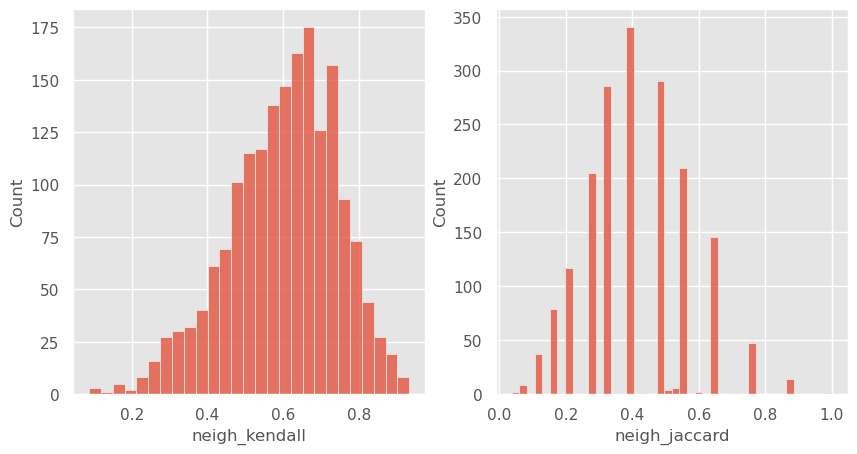

## coil-5 neighbors

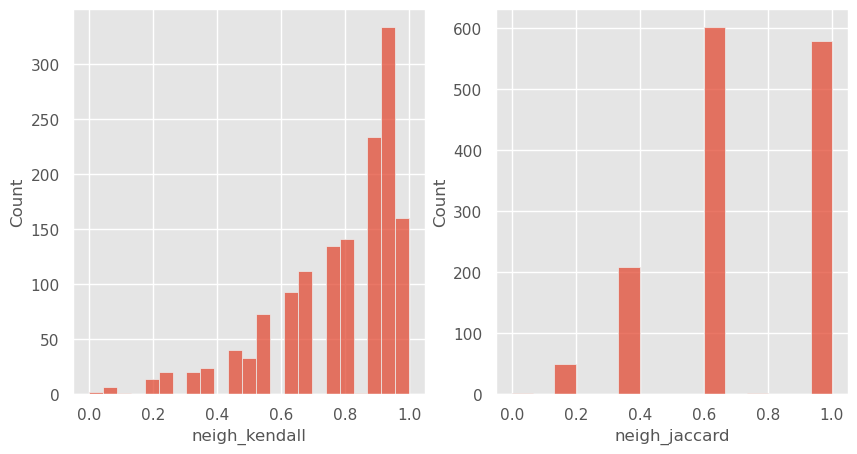

## mnist-10 neighbors

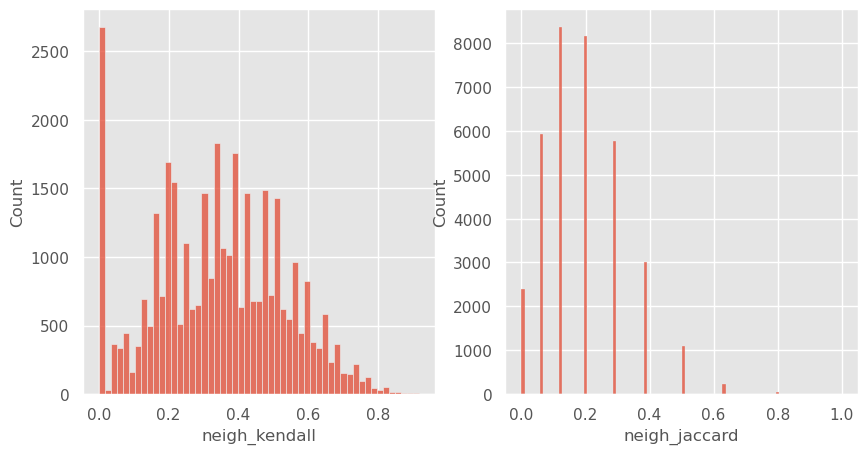

## usps-10 neighbors

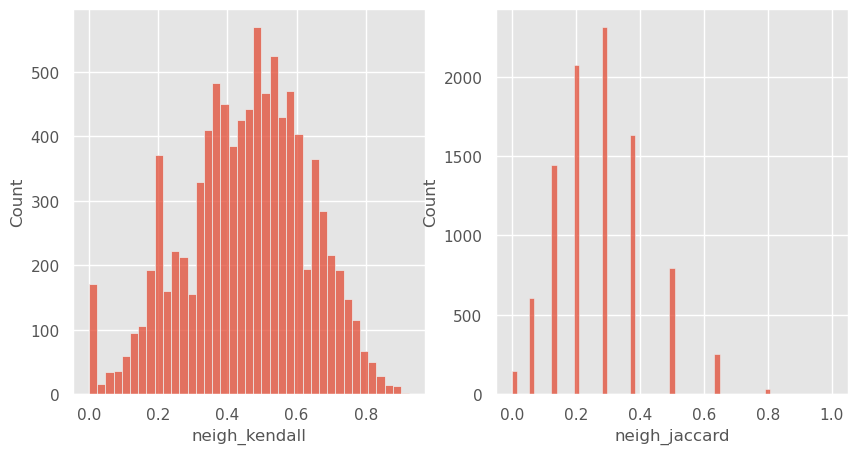

## buildings-8 neighbors

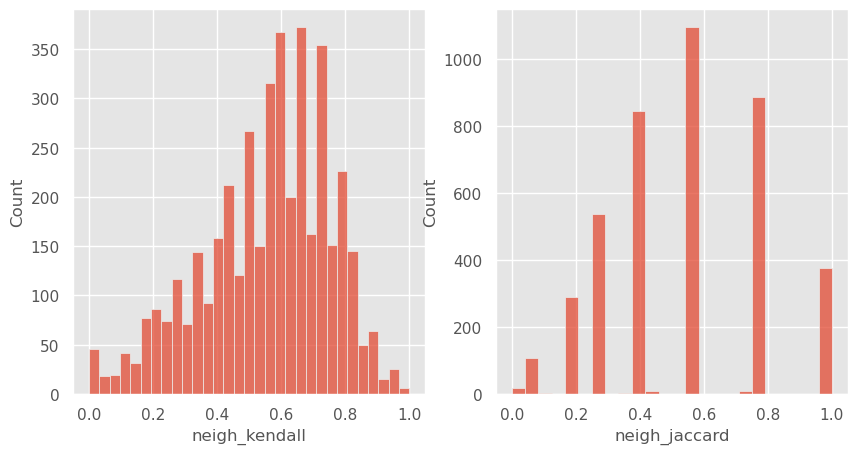

In [85]:
for i in range(5):
    vertex_neighborhood_sim(dataset_id=i)

# Edge measures vs their status in the groundtruth partition

In [35]:
what_vars_to_plot = ['highdist_dist', 'lowdim_dist','umap_weight', 'highdist_rank', 'lowdist_rank', 'umap_rank']

In [28]:
dataset_id = 0
set_op_mix_ratio = 1
params = get_dataset_params(dataset_id)
raw_data, targets, dataset_name = get_dataset(dataset_id)
G = knn_digraph(raw_data, params['n_neighbors'])
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

umap_rep = get_umap_vectors(dataset_id=dataset_id)
hd_umap_labels = hdbscan.HDBSCAN(min_samples=params['min_samples'], min_cluster_size=params['min_cluster_size']).fit_predict(umap_rep)

G = graph_edge_class_from_labels(G, hd_umap_labels, attribute_name = 'hd_internal')

ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

In [29]:
G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)

In [31]:
edge_df = G.get_edge_dataframe()
edge_df['true_vs_hd'] = list(zip(edge_df.internal, edge_df.hd_internal))
edge_df['true_vs_leiden'] = list(zip(edge_df.internal, edge_df.leiden_internal))
mapping = {(True, True):'True pos', (False, False):'True neg', (True, False):'False neg', (False, True):'False pos'}
edge_df['HDBSCAN'] = [mapping[x] for x in edge_df['true_vs_hd']]
edge_df['Leiden'] = [mapping[x] for x in edge_df['true_vs_leiden']]
edge_df[0:3]

,source,target,weight,bi_directional,internal,hd_internal,leiden_internal,umap_weight,nb_triangles,lowdim_dist,highdist_dist,highdist_rank,lowdist_rank,umap_rank,true_vs_hd,true_vs_leiden,HDBSCAN,Leiden
edge ID,,,,,,,,,,,,,,,,,,
0,0,877,1.000000,True,True,True,True,1.000000,19,0.140245,10.954452,0,4,13,"(True, True)","(True, True)",True pos,True pos
1,0,1365,0.470675,True,True,True,True,0.470675,17,0.055640,12.806249,1,0,12,"(True, True)","(True, True)",True pos,True pos
2,0,1541,0.415121,True,True,True,True,0.415121,18,0.286754,13.114877,2,7,11,"(True, True)","(True, True)",True pos,True pos


Counter({True: 24015, False: 1143})


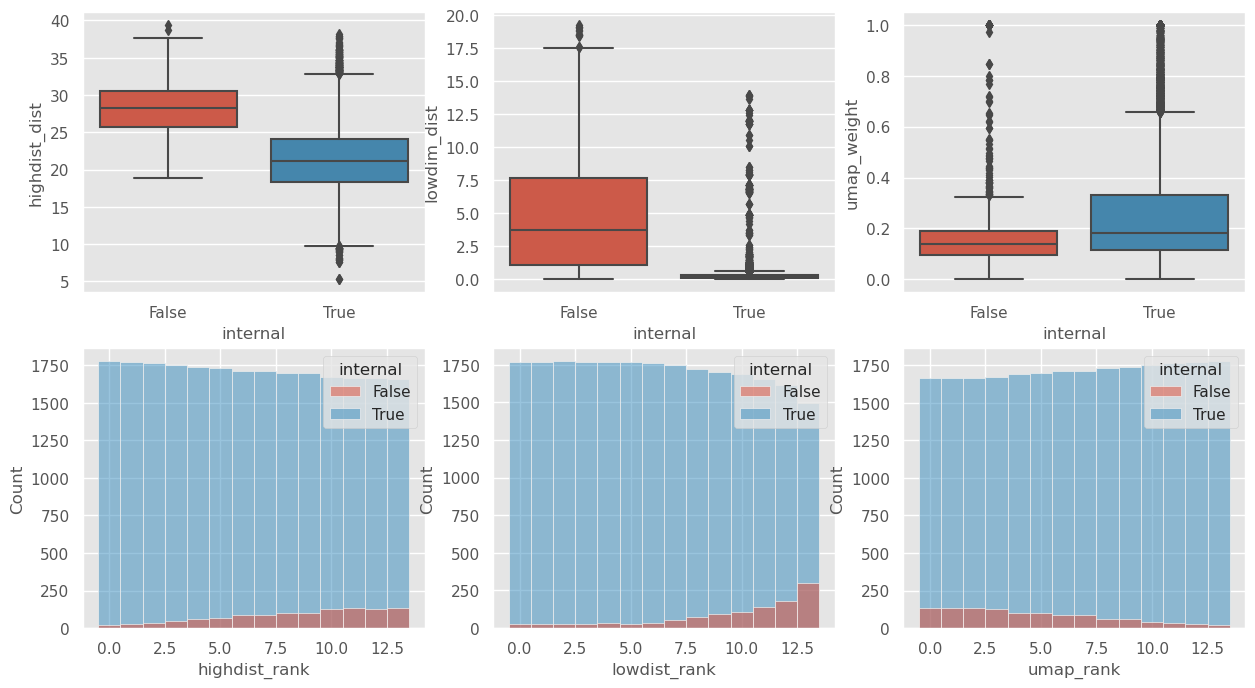

In [32]:
barPlot_split_on(what = what_vars_to_plot,
                 split_on='internal', 
                 edge_df=edge_df)

## Run the same analysis on all other datasets

In [33]:
def what_we_do_here(dataset_id, what_vars_to_plot, set_op_mix_ratio=1):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    params = get_dataset_params(dataset_id)
    G = knn_digraph(raw_data, params['n_neighbors'])
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

    umap_rep = get_umap_vectors(dataset_id=dataset_id)
    hd_umap_labels = hdbscan.HDBSCAN(min_samples=params['min_samples'], min_cluster_size=params['min_cluster_size']).fit_predict(umap_rep)

    G = graph_edge_class_from_labels(G, hd_umap_labels, attribute_name = 'hd_internal')

    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    G = enrich_graph_edge_properties(G, 
                                 vertex_high_representation=raw_data, 
                                 vertex_low_representation=umap_rep)
    
    edge_df = G.get_edge_dataframe()
    edge_df['true_vs_hd'] = list(zip(edge_df.internal, edge_df.hd_internal))
    edge_df['true_vs_leiden'] = list(zip(edge_df.internal, edge_df.leiden_internal))
    mapping = {(True, True):'True pos', (False, False):'True neg', (True, False):'False neg', (False, True):'False pos'}
    edge_df['HDBSCAN'] = [mapping[x] for x in edge_df['true_vs_hd']]
    edge_df['Leiden'] = [mapping[x] for x in edge_df['true_vs_leiden']]
    
    barPlot_split_on(what = what_vars_to_plot,
                 split_on='internal', 
                 edge_df=edge_df)
    plt.show()

## pendigits

Counter({True: 24015, False: 1143})


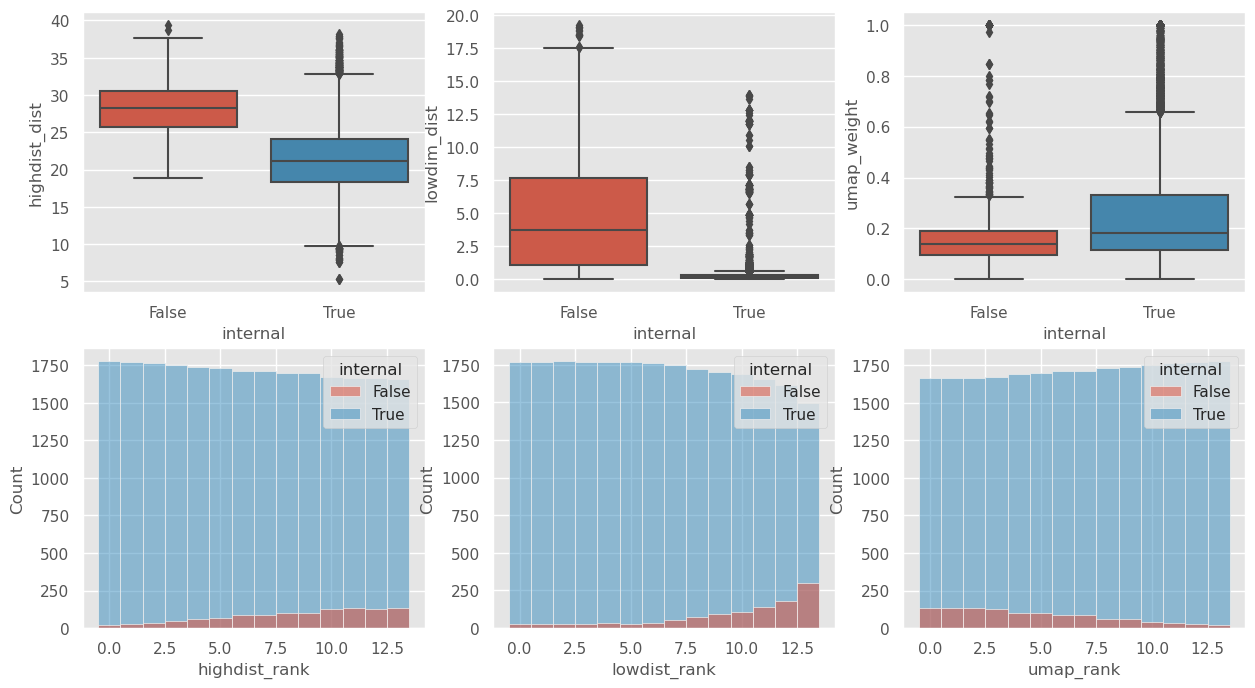

## coil

Counter({True: 5579, False: 181})


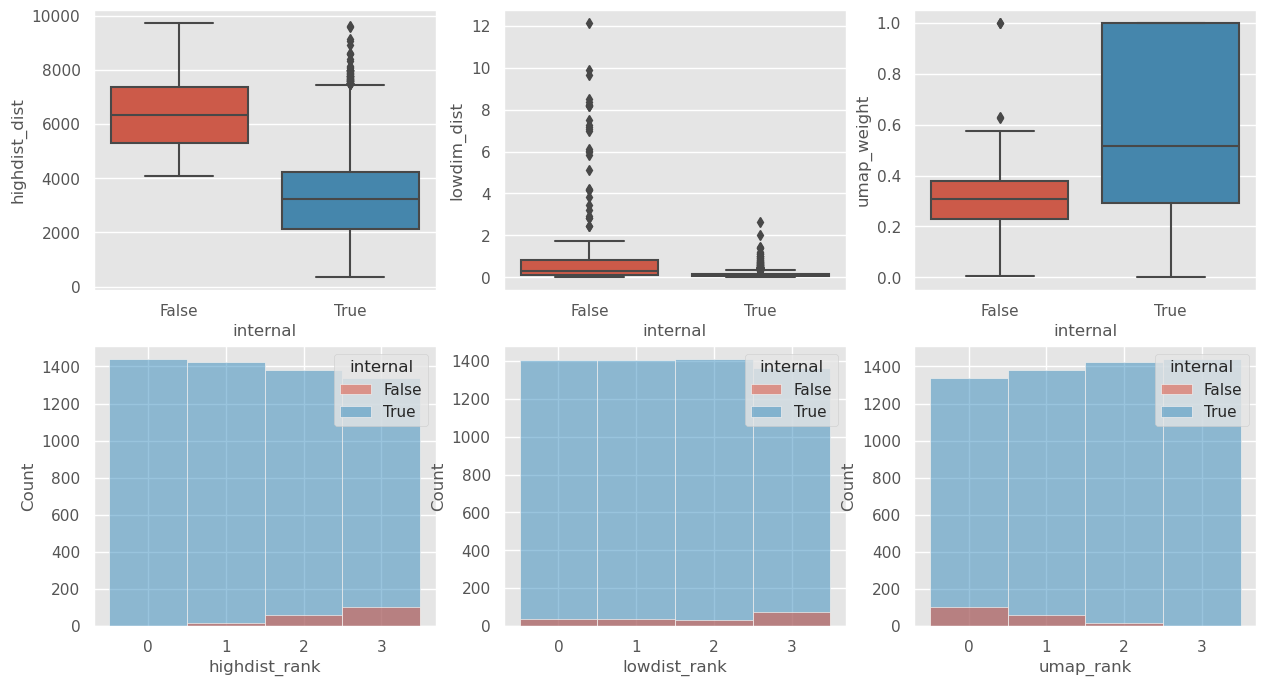

## mnist

Counter({True: 296707, False: 18293})


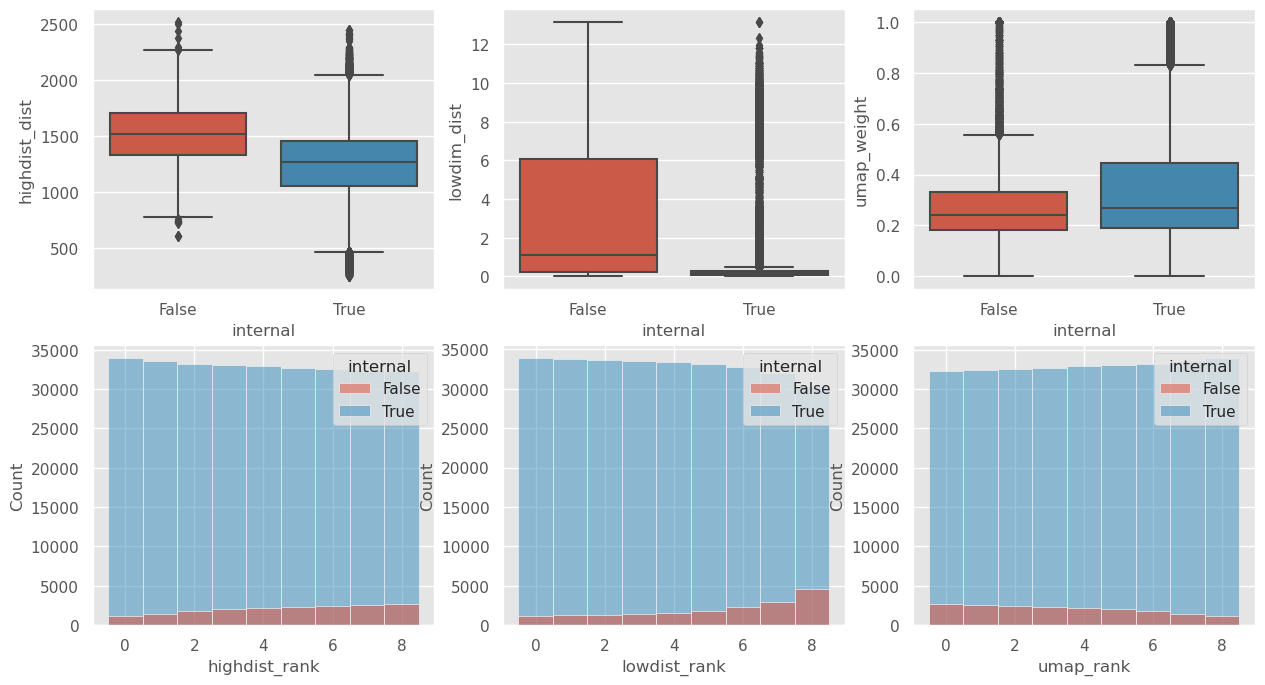

## usps

Counter({True: 79438, False: 4244})


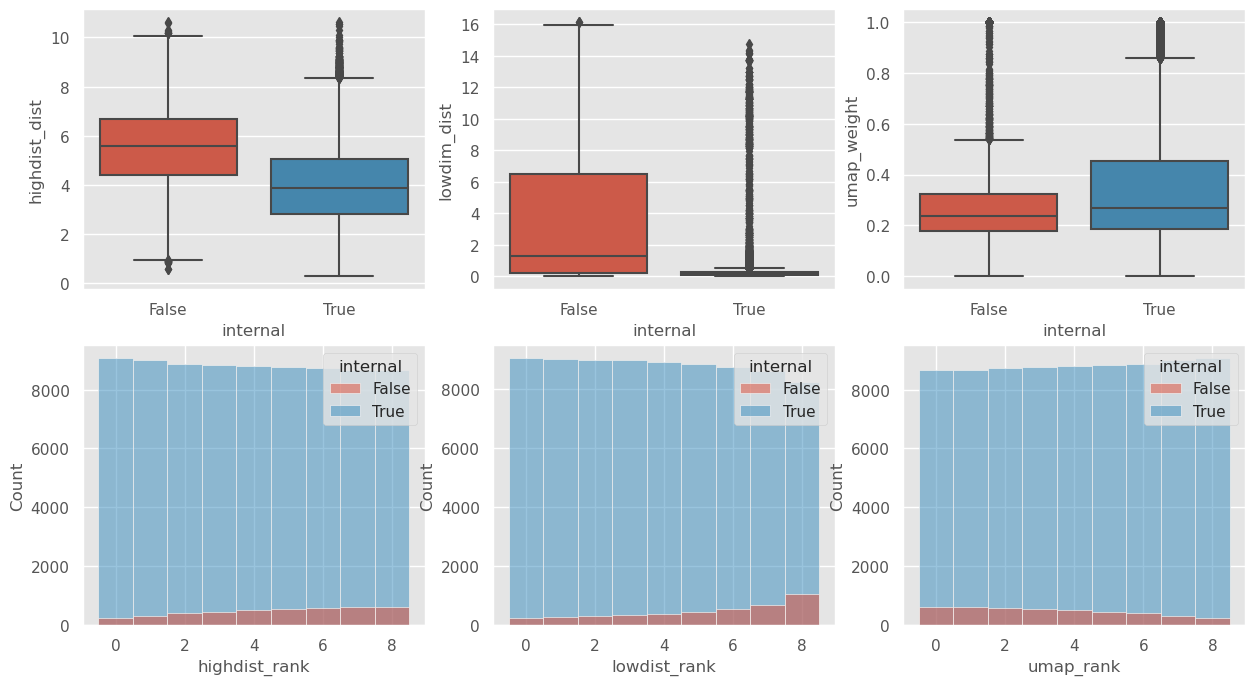

## buildings

Counter({True: 24269, False: 4893})


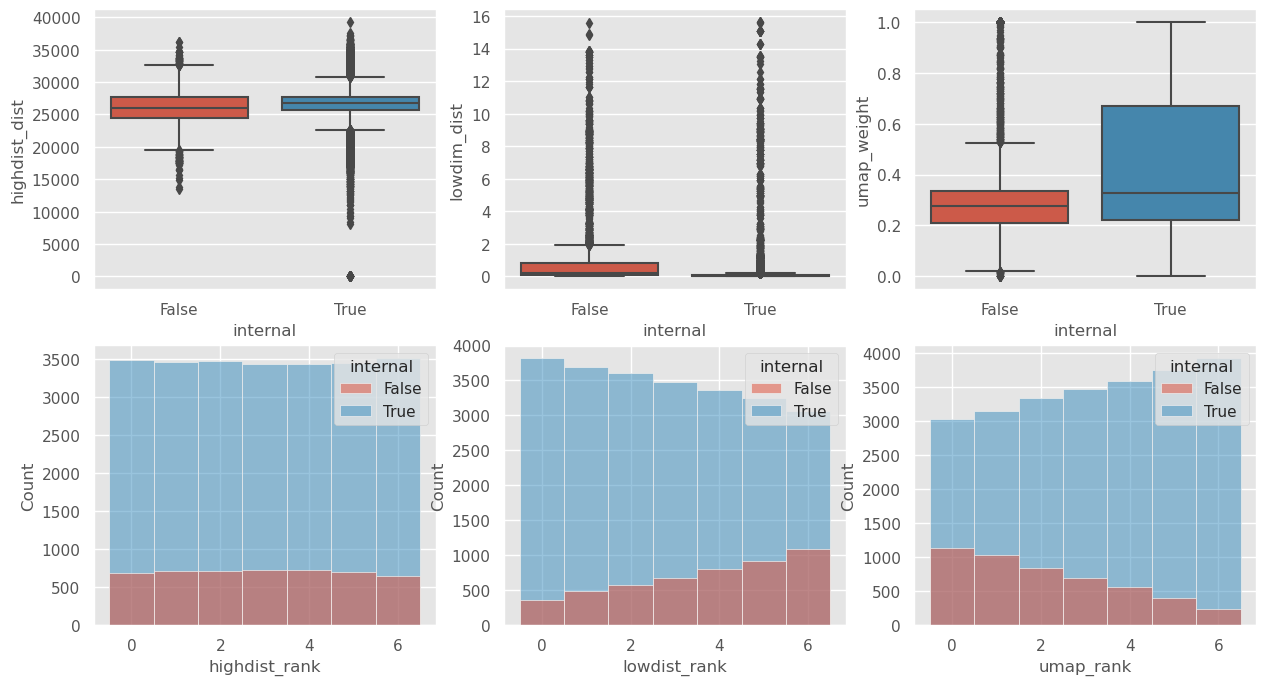

In [34]:
for i in range(5):
    what_we_do_here(dataset_id=i, what_vars_to_plot=what_vars_to_plot)